# Polygonal Prisms for fatiando

This code transform a list of prisms with vertices in polar coordinates into a list of classes of polygonal prisms using fatiando.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
import mag_polyprism_functions as mfun
% matplotlib inline

### Polygonal prisms

In [2]:
inc, dec = -60., 50. # inclination and declination of regional field
incs, decs = 70., -50.      # wrong direction or remanent

In [3]:
Np = 10 # number of prisms
Nv = 10 # number of vertices

r = 1000. # radial distance for each vertice
ang = 2.*np.pi/Nv  # angle between two vertices

In [4]:
verts = []  # list of vertices

### creating vertices

for i in range(Nv):
    verts.append([r, i*ang])

In [5]:
props={'magnetization': utils.ang2vec(3, inc, dec)} # physical property

dz = 100.   # thickness of each prism

m = []   # list of prisms

### creating the lis of prisms

k = 1.
for i in range(Np):
    m.append([verts, dz*k, dz*(k + 1), props])
    k = k + 1

In [6]:
model = mfun.pol2cart(m, Np, Nv)

# Observation points

In [7]:
#area over which the data are calculated
#x minimum, x maximum, y minimum and y maximum
area = [-10000, 10000, -10000, 10000] 

#number of data along the y and x directions
shape = (80,50)

#total number of data
N = shape[0]*shape[1]

#coordinates x and y of the data
x = np.linspace(area[0],area[1],shape[0]) # points in x
y = np.linspace(area[2],area[3],shape[0]) # points in y
xp,yp = np.meshgrid(x,y)    # creating mesh points
xp = xp.ravel()
yp = yp.ravel()

#vertical coordinates of the data
zp = -350. - 500.*utils.gaussian2d(xp, yp, 17000, 21000, 21000, 18500, angle=21) # relief

### Total field anomaly (TFA) for polygonal prisms (fatiando)

In [8]:
tfat = polyprism.tf(xp, yp, zp, model, inc, dec)

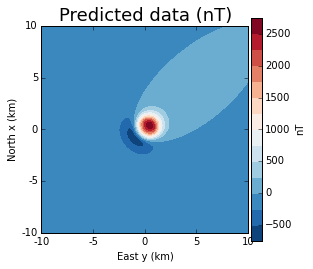

In [9]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Predicted data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, tfat,(80,80), 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.show()
